In [59]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

from hr.util import synth_sine, esprit, least_squares, \
    psd_noise_sig, noise_filtre_coeffs, whiten, _PINK_FILTRE_COEFFS, \
    ester_inverse_error_func, ester
from util.util import to_db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [25]:
sr = 44100
n_s = 100000
n_fft = 1024

r = 8 # number of sinusoids

deltas = rng.uniform(0.001, 0.01, r)
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_sine = synth_sine(n_s, deltas, nus, amps, phis) 

print(nus * sr)
print(deltas * sr)

[3711.90703018 3699.13199887 4624.25393767 1045.32345363 7038.72625954
 2930.24726624 6615.59407035 4710.5880781 ]
[314.92545452  65.46156236 131.5608335  117.27717167 113.91705214
 366.42030969 410.57562972 153.87237849]


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


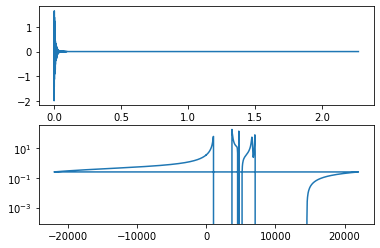

In [26]:
ts_plot = np.arange(n_s) / sr # times in seconds
nus_plot = np.fft.fftfreq(n_fft)

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.semilogy(nus_plot * sr, x_sine_ft)

In [11]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

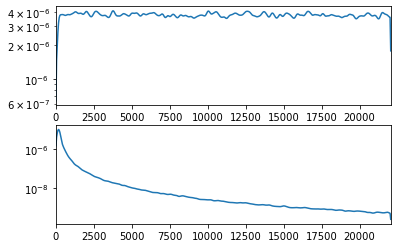

In [51]:
import colorednoise as cn

white_noise = rng.random(n_s)

pink_noise = cn.powerlaw_psd_gaussian(2, n_s)    # synthesizing noise
#pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft)

plt.figure()
plt.title("White and pink noises")
plt.subplot(2, 1, 1)
plt.semilogy(fs_psd, white_noise_psd)
plt.xlim(np.array([0, 0.5])*sr)
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_psd, pink_noise_psd)
plt.show()

/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


width=1378.125 Hz, 32.0 samples
width=1378.125 Hz, 32.0 samples
width=1378.125 Hz, 32.0 samples


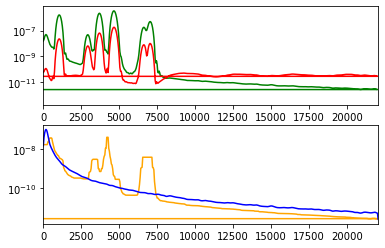

In [143]:
noise_ratio = 0.1
noise = noise_ratio*pink_noise
x = x_sine + noise

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft)

smoothing_factor = 4
ar_ordre = 14
noise_psd_est = psd_noise_sig(x, fs=sr, n_fft=n_fft, smoothing_factor=smoothing_factor)


noise_filtre_coeffs_est = noise_filtre_coeffs(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, smoothing_factor=smoothing_factor)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = whiten(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.title("PSD of the noised synthesised signal")
plt.subplot(2, 1, 1)
plt.xlim(np.array([0, 0.5]) * sr)
plt.semilogy(fs_x_psd, x_psd, c='green')
plt.semilogy(fs_x_psd, x_white_psd, c='r')
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_x_psd, noise_psd_est, c='orange')
plt.semilogy(fs_noise_psd, noise_psd, c='b')
plt.show()

In [146]:
ipd.Audio(np.real(x_sine)/np.max(np.abs(x_sine)), rate=sr)
# ipd.Audio(np.real(x)/np.max(np.abs(x)), rate=sr)
# ipd.Audio(np.real(x_white)/np.max(np.abs(x_white)), rate=sr)


### ESM model ordre estimation

#### Does not seem to be resistant to noise!

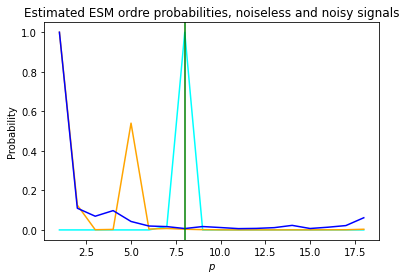

[7.30203785e+02 2.98379997e+02 6.22982905e+01 1.41497227e+04
 8.05766725e+02 6.42246502e+05 2.93410711e+08 1.70687709e+10
 1.77685859e+00 1.84291107e+00 1.52540874e+00 1.49520650e+00
 1.18804723e+00 1.15196083e+00 1.11176043e+00 1.25559805e+00
 1.28893521e+00 1.70033366e+00]
[ 0  3  7  9 17]
[1.78302204e+04 2.23648061e+03 1.77800266e+01 4.38361079e+01
 9.63092075e+03 7.38454968e+01 1.29197271e+02 6.32727915e+01
 2.38254066e+01 7.98211962e+00 3.00152717e+00 5.08539186e+00
 3.88588718e+00 6.52031660e+00 5.79871274e+00 1.10763530e+01
 1.43848268e+01 5.93965855e+01]
[ 0  4  6 11 13 17]
[601.53167209  66.00579788  41.68705765  58.74710265  25.6916633
  11.84806772  10.06633958   4.20552722  10.26915275   7.22877899
   3.93634425   4.61656347   6.90517473  13.83155356   4.32119431
   8.23057156  13.22890055  37.02598222]
[ 0  3  8 13 17]
Ordre of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=5, Whitened=1


In [147]:
n_est = 20
p_max = n_est - 2 # for now
thresh_ratio = 0.1
ps = np.arange(1,p_max+1)
j_sine = ester_inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = ester_inverse_error_func(x, n=n_est, p_max=p_max)
j_white = ester_inverse_error_func(x_white, n=n_est, p_max=p_max)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

r_est_sine = ester(x_sine, n_est, p_max, thresh_ratio=thresh_ratio)
r_est_noise = ester(x, n_est, p_max, thresh_ratio=thresh_ratio)
r_est_white = ester(x_white, n_est, p_max, thresh_ratio=thresh_ratio)
print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')


### Test of the model with noiseless signal

[0.08417023 0.08388054 0.10485837 0.02370348 0.15960831 0.06644552
 0.15001347 0.10681606]
[-2.09282234e-05  2.30989228e-02  1.55441605e-01  8.17747707e-02
  1.04360204e-01]
[0.00714117 0.00148439 0.00298324 0.00265935 0.00258315 0.00830885
 0.0093101  0.00348917]
[9.83841925e-05 5.59522861e-03 1.27884157e-02 1.16116946e-02
 5.74050958e-03]


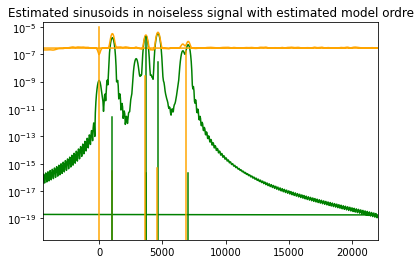

In [34]:
deltas_est, nus_est = esprit(x_white, n_est, r_est_white)
amps_est, phis_est = least_squares(x_white, deltas, nus)

print(nus)
print(nus_est)
print(deltas)
print(deltas_est)

plt.title("Estimated sinusoids in noiseless signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='g')
plt.semilogy(fs_x_psd, x_white_psd, c='orange')
for j in range(len(nus_est)):
    plt.axvline(nus[j] * sr, 0, amps[j], c='g')
    plt.axvline(nus_est[j] * sr, 0, amps_est[j], c='orange')
plt.show()

### Filter bank

In [33]:
# number of bands
n_fb = 32
m_fb = n_fb//2
step_fb = 1

fs_fb, ts_fb, x_stft = sig.stft(x_sine, fs=sr,
    nperseg=m_fb, nfft=n_fb)

fs_centre = np.fft.fftfreq(n=n_fb)

rs = [None] * n_fb
deltas_est = []
nus_est = []
amps_est = []
phis_est = []

n_est_fb = 5
p_max_fb = 3
for k in range(len(fs_centre)):
    x_b = x_stft[k]
    rs[k] = ester(x_b, n=n_est_fb, p_max=p_max_fb)
    deltas_est_band, nus_est_band = esprit(x_b, n_est, rs[k])
    amps_est_band, phis_est_band = least_squares(x_b, deltas, nus)
    nus_est_band += fs_centre[k]
    nus_est += nus_est_band.tolist()
    deltas_est += deltas_est_band.tolist()
    amps_est += amps_est_band.tolist()
    phis_est += phis_est_band.tolist()
nus_est = np.sort(nus_est)
print(rs)
print(nus_est * sr)
# rs = ester(x_stft, n=n_est, p_max=p_max)


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


[1, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1, 1]
[-3.58469228e+04 -3.09806896e+04 -2.65256985e+04 -2.56644757e+04
 -2.35233742e+04 -2.19007190e+04 -1.64711465e+04 -1.62894211e+04
 -1.43858287e+04 -1.32066530e+04 -1.18096094e+04 -1.04060459e+04
 -9.01462377e+03 -7.82438901e+03 -7.60520419e+03 -5.56978028e+03
 -4.18153457e+03 -2.79215601e+03 -1.40714176e+03 -1.96925099e+01
 -3.25586920e+00  1.10272087e+01  2.86224056e+01  1.24518769e+03
  2.89190144e+03  3.52991290e+03  3.55807123e+03  4.18966050e+03
  5.57066459e+03  6.37507001e+03  6.97531642e+03  7.60541918e+03
  8.36454401e+03  9.74231908e+03  1.10897889e+04  1.28635710e+04
  1.63960882e+04  1.77811029e+04  2.03980077e+04  2.18899326e+04
  2.32960752e+04  2.33456766e+04  3.26039894e+04]
